# Introduction

this code is trying to classify movie reviews by using concatenating the sentence embedding generated by CNN and Bert together. And the static word embedding used by CNN is Word2Vec 



# Import section

In [ ]:
pip install transformers

     |████████████████████████████████| 2.3MB 14.5MB/s 
     |████████████████████████████████| 901kB 54.3MB/s 
     |████████████████████████████████| 3.3MB 44.9MB/s 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess
from gensim.parsing.porter import PorterStemmer
import torch
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from gensim.models import Word2Vec
import gensim
from tqdm import tqdm
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from collections import Counter
from sklearn.metrics import accuracy_score

import transformers
from transformers import AutoModel, BertTokenizerFast

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
from transformers import BertModel
from transformers import AdamW
import pickle

In [ ]:
# specify GPU
device = torch.device("cuda")
print(device)

cuda


# Load Data

In [ ]:
df = pd.read_csv("movie_review_RT50K.csv")
print(df.shape)
df.head(3)

(50000, 2)


,content,sentiment
0,"Compelling in fits and starts, actor-director ...",0
1,Quite simply one of the finest comic romances ...,1
2,A psychological thriller that dangles over the...,0


# Preprocessing (Generating Embeddings)

In [ ]:
df['tokenized_text'] = [simple_preprocess(text, deacc=True) for text in df['content']] 
df['tokenized_text'].head(5)

0    [compelling, in, fits, and, starts, actor, dir...
1    [quite, simply, one, of, the, finest, comic, r...
2    [psychological, thriller, that, dangles, over,...
3    [the, general, is, something, of, salute, to, ...
4    [you, think, that, movie, that, opens, with, g...
Name: tokenized_text, dtype: object

In [ ]:
porter_stemmer = PorterStemmer()
df['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in df['tokenized_text'] ]
df['stemmed_tokens'].head(5)

0    [compel, in, fit, and, start, actor, director,...
1    [quit, simpli, on, of, the, finest, comic, rom...
2    [psycholog, thriller, that, dangl, over, the, ...
3    [the, gener, is, someth, of, salut, to, boorma...
4    [you, think, that, movi, that, open, with, gra...
Name: stemmed_tokens, dtype: object

In [ ]:
df.head(5)

,content,sentiment,tokenized_text,stemmed_tokens
0,"Compelling in fits and starts, actor-director ...",0,"[compelling, in, fits, and, starts, actor, dir...","[compel, in, fit, and, start, actor, director,..."
1,Quite simply one of the finest comic romances ...,1,"[quite, simply, one, of, the, finest, comic, r...","[quit, simpli, on, of, the, finest, comic, rom..."
2,A psychological thriller that dangles over the...,0,"[psychological, thriller, that, dangles, over,...","[psycholog, thriller, that, dangl, over, the, ..."
3,The General is something of a salute to Boorma...,1,"[the, general, is, something, of, salute, to, ...","[the, gener, is, someth, of, salut, to, boorma..."
4,You'd think that a movie that opens with a gra...,0,"[you, think, that, movie, that, opens, with, g...","[you, think, that, movi, that, open, with, gra..."


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df[['content','tokenized_text','stemmed_tokens']], 
                                                    df['sentiment'], 
                                                    shuffle=True,
                                                    test_size=0.2, 
                                                    random_state=2021)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(40000, 3)
(40000,)
(10000, 3)
(10000,)


In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, 
                                                    Y_train, 
                                                    shuffle=True,
                                                    test_size=0.1, 
                                                    random_state=2021)
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)

(36000, 3)
(36000,)
(4000, 3)
(4000,)


In [ ]:
OUTPUT_FOLDER='w2c/'
size = 500 #embedding length
window = 3 #Maximum distance between the current and predicted word within a sentence.
min_count = 1 # Ignores  words with counts lower than this.
workers = 2
sg = 1 # sg Training algorithm: 1 for skip-gram; otherwise CBOW.


def make_word2vec_model(df, padding=True, sg=1, min_count=1, size=500, workers=2, window=3):
    if  padding:
        temp_df = pd.Series(df['stemmed_tokens']).values
        temp_df = list(temp_df)
        temp_df.append(['pad'])
        word2vec_file = OUTPUT_FOLDER + 'models/' + 'word2vec_' + str(size) + '_PAD.model'
    else:
        temp_df = df['stemmed_tokens']
        word2vec_file = OUTPUT_FOLDER + 'models/' + 'word2vec_' + str(size) + '.model'

    w2v_model = Word2Vec(temp_df, min_count = min_count, size = size, workers = workers, window = window, sg = sg)

    w2v_model.save(word2vec_file)
    return w2v_model

# Train Word2vec model, word2vec_file is only a str
w2vmodel = make_word2vec_model(df, padding=True, sg=sg, min_count=min_count, size=size, workers=workers, window=window)

In [ ]:
#get the maximum length
max_sen_len = df.stemmed_tokens.map(len).max()
print('max length of stemmed tokens',max_sen_len)

#get the padding word index
padding_idx = w2vmodel.wv.vocab['pad'].index
print('padding index',padding_idx)

#generate the torch tensor of the sentence, using token id, pad id of the 'pad' all the way to the end of 390, which is the longest sentence
def make_word2vec_vector_cnn(sentence):
    padded_X = [padding_idx for i in range(max_sen_len)]
    i = 0
    for word in sentence:
        if word not in w2vmodel.wv.vocab:
            padded_X[i] = 0
            print('unknown word:',word)
        else:
            padded_X[i] = w2vmodel.wv.vocab[word].index
        i += 1
    
    return torch.tensor(padded_X, dtype=torch.long).view(1, -1)


max length of stemmed tokens 50
padding index 2571


In [ ]:
def make_target(target):    
    if target == 0:
        return torch.tensor([0], dtype=torch.long)
    elif target == 1:
        return torch.tensor([1], dtype=torch.long)
make_target(1)

tensor([1])

In [ ]:
def changeInput(X,Y):
  X_Vec=list([])
  Y_Vec=list([])

  for i in range(len(X)):
    bow_vec = make_word2vec_vector_cnn(X.iloc[i]['stemmed_tokens'])
    X_Vec.append(bow_vec)
    Y_Vec.append(make_target(Y.iloc[i]))
          
  X_Vec=torch.cat(X_Vec,dim=-2)
  Y_Vec=torch.cat(Y_Vec,dim=0)

  return X_Vec,Y_Vec

CNN_X_train_Vec,CNN_Y_train_Vec=changeInput(X_train,Y_train)
print(CNN_X_train_Vec.shape)
print(CNN_Y_train_Vec.shape)

CNN_X_test_Vec,CNN_Y_test_Vec=changeInput(X_test,Y_test)
print(CNN_X_test_Vec.shape)
print(CNN_Y_test_Vec.shape)

CNN_X_valid_Vec,CNN_Y_valid_Vec=changeInput(X_valid,Y_valid)
print(CNN_X_valid_Vec.shape)
print(CNN_Y_valid_Vec.shape)

torch.Size([36000, 50])
torch.Size([36000])
torch.Size([10000, 50])
torch.Size([10000])
torch.Size([4000, 50])
torch.Size([4000])


# Preprocessing (Bert Embeddings)

In [ ]:
# bert = AutoModel.from_pretrained('bert-base-uncased',output_hidden_states=True)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
# tokenize and encode the training set
tokens_train = tokenizer.batch_encode_plus(
    X_train.content.tolist(),
    max_length = 50,
    truncation=True,
    padding='max_length',
)

# tokenize and encode the validation set
tokens_val = tokenizer.batch_encode_plus(
    X_valid.content.tolist(),
    max_length = 50,
    truncation=True,
    padding='max_length',
)

# tokenize and encode the test set
tokens_test = tokenizer.batch_encode_plus(
    X_test.content.tolist(),
    max_length = 50,
    truncation=True,
    padding='max_length',
)

In [ ]:
BERT_train_seq = torch.tensor(tokens_train['input_ids'])
BERT_train_mask = torch.tensor(tokens_train['attention_mask'])
BERT_train_y = torch.tensor(Y_train.tolist())

BERT_val_seq = torch.tensor(tokens_val['input_ids'])
BERT_val_mask = torch.tensor(tokens_val['attention_mask'])
BERT_val_y = torch.tensor(Y_valid.tolist())

BERT_test_seq = torch.tensor(tokens_test['input_ids'])
BERT_test_mask = torch.tensor(tokens_test['attention_mask'])
BERT_test_y = torch.tensor(Y_test.tolist())

print(BERT_train_seq.shape)
print(BERT_train_mask.shape)
print(BERT_train_y.shape)
print()

print(BERT_val_seq.shape)
print(BERT_val_mask.shape)
print(BERT_val_y.shape)
print()

print(BERT_test_seq.shape)
print(BERT_test_mask.shape)
print(BERT_test_y.shape)

torch.Size([36000, 50])
torch.Size([36000, 50])
torch.Size([36000])

torch.Size([4000, 50])
torch.Size([4000, 50])
torch.Size([4000])

torch.Size([10000, 50])
torch.Size([10000, 50])
torch.Size([10000])


# first train the  Bert model

In [ ]:
bert = AutoModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
for name, param in list(bert.named_parameters())[:-100]: 
    param.requires_grad = False

In [ ]:
class myBERT(nn.Module):

    def __init__(self, bert):    
      super(myBERT, self).__init__()      
      self.bert = bert     
      self.dropout = nn.Dropout(0.1)     
      self.relu =  nn.ReLU()
      self.fc1 = nn.Linear(768,512)  #last layer of bert is of size 768
      self.fc2 = nn.Linear(512,2)    
      self.softmax = nn.LogSoftmax(dim=1)


    def forward(self, sent_id, attention_mask):

      output = self.bert(sent_id, attention_mask)
      x=self.fc1(output['pooler_output'])
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)
      x = self.softmax(x)

      return x


In [ ]:
%%time

BATCH_SIZE=100

modelBert=myBERT(bert)
modelBert.to(device)


optimizer = AdamW(modelBert.parameters(),lr = 1e-4)   
loss_function=nn.CrossEntropyLoss()
num_epochs=10

train_loss=[]

modelBert.train()   #to speicify the training condition


for epoch in range(num_epochs):
    print("Epoch" + str(epoch + 1),'started')
    trainLoss = 0

    for i in tqdm(range(0,len(BERT_train_seq),BATCH_SIZE)):

        modelBert.zero_grad()
        
        endIndex=min(i+BATCH_SIZE,len(BERT_train_seq))
        sent_id= BERT_train_seq[i:endIndex].to(device)
        mask   = BERT_train_mask[i:endIndex].to(device)
        labels = BERT_train_y[i:endIndex].to(device)      

        output = modelBert(sent_id, mask)
        loss = loss_function(output, labels)
        trainLoss = trainLoss + loss.item()        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(modelBert.parameters(), 1.0)
        optimizer.step()                
    
    trainLoss=round(trainLoss / len(BERT_train_seq),5)  
    print()        
    print(trainLoss)  
    

  0%|          | 1/360 [00:00<01:06,  5.37it/s]

Epoch1 started


  0%|          | 1/360 [00:00<01:01,  5.83it/s]


0.00399
Epoch2 started


  0%|          | 1/360 [00:00<01:03,  5.61it/s]


0.00285
Epoch3 started


  0%|          | 1/360 [00:00<01:02,  5.78it/s]


0.00193
Epoch4 started


  0%|          | 1/360 [00:00<01:03,  5.65it/s]


0.00137
Epoch5 started


  0%|          | 1/360 [00:00<01:02,  5.72it/s]


0.00101
Epoch6 started


  0%|          | 1/360 [00:00<01:01,  5.80it/s]


0.00078
Epoch7 started


  0%|          | 1/360 [00:00<01:02,  5.72it/s]


0.00067
Epoch8 started


  0%|          | 1/360 [00:00<01:04,  5.57it/s]


0.0006
Epoch9 started


  0%|          | 1/360 [00:00<01:02,  5.76it/s]


0.00046
Epoch10 started


100%|██████████| 360/360 [01:03<00:00,  5.65it/s]


0.00047
CPU times: user 10min 37s, sys: 3.64 s, total: 10min 40s
Wall time: 10min 37s


In [ ]:
BATCH_SIZE=200
y_pred = []
modelBert.eval()

with torch.no_grad():
     for i in tqdm(range(0,len(BERT_test_seq),BATCH_SIZE)):
        endIndex=min(i+BATCH_SIZE,len(BERT_test_seq))

        sent_id=BERT_test_seq[i:endIndex].to(device)
        mask=BERT_test_mask[i:endIndex].to(device)

        output=modelBert(sent_id, mask)     
        predicted_class=torch.argmax(output,dim=-1).cpu().tolist()        
        y_pred.extend(predicted_class)      

print()
print(classification_report(Y_test.tolist(),y_pred))

100%|██████████| 50/50 [00:07<00:00,  6.52it/s]


              precision    recall  f1-score   support

           0       0.88      0.80      0.84      5028
           1       0.82      0.89      0.85      4972

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [ ]:
t=0
for param in bert.parameters():
    if param.requires_grad == True:
      t+=1
print('number of active layers',t)

number of active layers 100


freeze all the layers

In [ ]:
for param in bert.parameters():
  param.requires_grad = False

Empty Cache

In [ ]:
modelBert.cpu()
torch.cuda.empty_cache() 

# define classifier

In [ ]:
NUM_CLASSES = 2
EMBEDDING_SIZE = 500
NUM_FILTERS = 10


class CNN_Bert_Model(nn.Module):

    def __init__(self, bert,num_classes, window_sizes=(1,2,3,5)):

        super(CNN_Bert_Model, self).__init__()        
        #CNN        
        weights = w2vmodel.wv
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights.vectors), padding_idx=w2vmodel.wv.vocab['pad'].index)
        self.convs = nn.ModuleList([
              nn.Conv2d(1, NUM_FILTERS, [window_size, EMBEDDING_SIZE], padding=(window_size - 1, 0))
              for window_size in window_sizes
        ])

        #Bert
        self.bert=bert

        #feedforward
        self.relu =  nn.ReLU()
        self.fc1=nn.Linear(NUM_FILTERS*len(window_sizes)+768,512)
        self.fc2 = nn.Linear(512, 2)
        self.dropout = nn.Dropout(0.1)    
        self.softmax = nn.LogSoftmax(dim=1)
        


    def forward(self, xCNN, Bert_sent_id, Bert_attention_mask):

        #first generate CNN
        xCNN = self.embedding(xCNN)     # [Batch, Text, Eembbeding]        #size ([1, 50, 500])
        xCNN = torch.unsqueeze(xCNN, 1) # Apply a convolution + max_pool layer for each window size   
        xs = []
        for conv in self.convs:
            x2=conv(xCNN)
            x2 = torch.tanh(x2)
            x2 = torch.squeeze(x2, -1)          #you can only squeeze if you know for sure that dimension is 1
            x2 = F.max_pool1d(x2, x2.size(2))   #max_pool1d can only take in 3 dimensional data, thats why you need to squeeze
            xs.append(x2)

        xCNN = torch.cat(xs, 2)        
        xCNN = xCNN.view(xCNN.size(0), -1) #only keep the batch ,(1,40)
        # print(xCNN.shape)

        # #genereate Bert
        outputBert = self.bert(Bert_sent_id, Bert_attention_mask)
        xBert=outputBert['pooler_output']
        # print(xBert.shape)

        #concatenate
        xCombine=torch.cat((xCNN,xBert),dim=1)
        # print(xCombine.shape)

        # Feed Forward layer

        x=self.fc1(xCombine)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        res = F.softmax(x, dim = 1)

        return res

# tcc=CNN_X_train_Vec[0].view(-1,50)
# tseq=BERT_train_seq[0].view(-1,50)
# tmask=BERT_train_mask[0].view(-1,50)
# model=CNN_Bert_Model(bert,num_classes=2)
# model.to(device)
# model(xCNN=tcc, Bert_sent_id=tseq, Bert_attention_mask=tmask)

# Training

In [ ]:
trainLen=len(BERT_train_seq)
testLen=len(BERT_test_seq)
validLen=len(BERT_val_seq)


In [ ]:
# val_seq val_mask val_y
def getValid():
  
  model.eval()
  with torch.no_grad():
    
    BATCH_SIZE=200
    temp_pred=[]
    validLoss=0

    for i in range(0,validLen,BATCH_SIZE):
      
      endIndex=min(i+BATCH_SIZE,validLen)

      tcc=CNN_X_valid_Vec[i:endIndex].to(device)
      sent_id= BERT_val_seq[i:endIndex].to(device)
      mask   = BERT_val_mask[i:endIndex].to(device)
      labels = BERT_val_y[i:endIndex].to(device)   

      output=model(xCNN=tcc, Bert_sent_id=sent_id, Bert_attention_mask=mask)   
           

      predicted_class=torch.argmax(output,dim=-1).cpu().tolist()        
      temp_pred.extend(predicted_class) 

      
      loss = loss_function(output, labels)


      validLoss += loss.item()


    validLoss=round(validLoss /validLen,5)
    validAcc=round(accuracy_score(Y_valid.tolist(), temp_pred),3)

  return validLoss,validAcc




In [ ]:
%%time

BATCH_SIZE=100

model=CNN_Bert_Model(bert,num_classes=2)
model.to(device)


optimizer = AdamW(model.parameters(),lr = 1e-4)   
loss_function=nn.CrossEntropyLoss()
num_epochs=10

train_loss=[]
val_loss=[]
val_acc=[]

model.train()   #to speicify the training condition


for epoch in range(num_epochs):
    print("Epoch" + str(epoch + 1),'started')
    trainLoss = 0

    
    for i in tqdm(range(0,trainLen,BATCH_SIZE)):

        
        model.zero_grad()
        
        endIndex=min(i+BATCH_SIZE,trainLen)

        tcc=CNN_X_train_Vec[i:endIndex].to(device)
        sent_id= BERT_train_seq[i:endIndex].to(device)
        mask   = BERT_train_mask[i:endIndex].to(device)
        labels = BERT_train_y[i:endIndex].to(device)    
        
        output=model(xCNN=tcc, Bert_sent_id=sent_id, Bert_attention_mask=mask)

        loss = loss_function(output, labels)
        trainLoss = trainLoss + loss.item()        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()                
    

    trainLoss=round(trainLoss / trainLen,5)

    validLoss,validAcc=getValid()


    train_loss.append(trainLoss)
    val_loss.append(validLoss)
    val_acc.append(validAcc)       

    model.train()  
    
    print('train loss',trainLoss) 
    print()


  0%|          | 1/360 [00:00<00:40,  8.83it/s]

Epoch1 started


  0%|          | 1/360 [00:00<00:36,  9.82it/s]

train loss 0.00331

Epoch2 started


  0%|          | 1/360 [00:00<00:36,  9.71it/s]

train loss 0.00325

Epoch3 started


  0%|          | 1/360 [00:00<00:36,  9.80it/s]

train loss 0.00324

Epoch4 started


  0%|          | 1/360 [00:00<00:36,  9.79it/s]

train loss 0.00324

Epoch5 started


  0%|          | 1/360 [00:00<00:37,  9.60it/s]

train loss 0.00324

Epoch6 started


  0%|          | 1/360 [00:00<00:36,  9.82it/s]

train loss 0.00324

Epoch7 started


  0%|          | 1/360 [00:00<00:36,  9.83it/s]

train loss 0.00324

Epoch8 started


  0%|          | 1/360 [00:00<00:36,  9.74it/s]

train loss 0.00324

Epoch9 started


  0%|          | 1/360 [00:00<00:37,  9.69it/s]

train loss 0.00323

Epoch10 started


100%|██████████| 360/360 [00:37<00:00,  9.72it/s]


train loss 0.00323

CPU times: user 6min 39s, sys: 3.06 s, total: 6min 42s
Wall time: 6min 40s


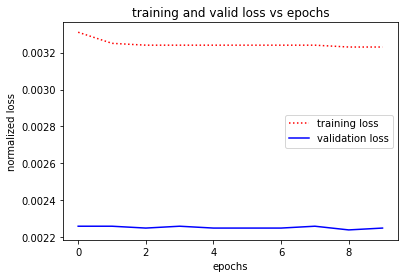

In [ ]:
epoch_list=[i for i in range(0,10)]
plt.plot( epoch_list,train_loss, label="training loss",linestyle='dotted',color='red')
plt.plot( epoch_list,val_loss, label="validation loss",color='blue')

plt.xlabel("epochs")
plt.ylabel("normalized loss")
plt.legend(loc="best")
plt.title('training and valid loss vs epochs')
plt.show()


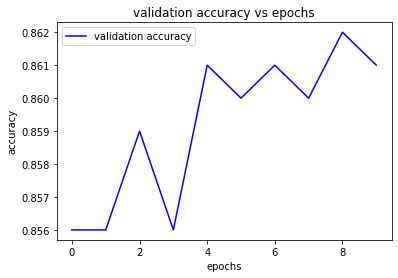

In [ ]:
epoch_list=[i for i in range(0,10)]
plt.plot( epoch_list,val_acc, label="validation accuracy",color='blue')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="best")
plt.title('validation accuracy vs epochs')
plt.show()


In [ ]:
BATCH_SIZE=200
y_pred = []
model.eval()

with torch.no_grad():
     for i in tqdm(range(0,testLen,BATCH_SIZE)):
        endIndex=min(i+BATCH_SIZE,testLen)

        tcc=CNN_X_test_Vec[i:endIndex].to(device)
        sent_id= BERT_test_seq[i:endIndex].to(device)
        mask   = BERT_test_mask[i:endIndex].to(device)

        output=model(xCNN=tcc, Bert_sent_id=sent_id, Bert_attention_mask=mask)
      
        predicted_class=torch.argmax(output,dim=-1).cpu().tolist()        
        y_pred.extend(predicted_class)      

print()
print(classification_report(Y_test.tolist(),y_pred))

100%|██████████| 50/50 [00:07<00:00,  6.47it/s]


              precision    recall  f1-score   support

           0       0.86      0.86      0.86      5028
           1       0.86      0.86      0.86      4972

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [ ]:
%%time

BATCH_SIZE=64

model=CNN_Bert_Model(bert,num_classes=2)
model.to(device)


optimizer = AdamW(model.parameters(),lr = 1e-4)   
loss_function=nn.CrossEntropyLoss()
num_epochs=20

train_loss=[]
val_loss=[]
val_acc=[]

model.train()   #to speicify the training condition


for epoch in range(num_epochs):
    print("Epoch" + str(epoch + 1),'started')
    trainLoss = 0

    
    for i in tqdm(range(0,trainLen,BATCH_SIZE)):

        
        model.zero_grad()
        
        endIndex=min(i+BATCH_SIZE,trainLen)

        tcc=CNN_X_train_Vec[i:endIndex].to(device)
        sent_id= BERT_train_seq[i:endIndex].to(device)
        mask   = BERT_train_mask[i:endIndex].to(device)
        labels = BERT_train_y[i:endIndex].to(device)    
        
        output=model(xCNN=tcc, Bert_sent_id=sent_id, Bert_attention_mask=mask)

        loss = loss_function(output, labels)
        trainLoss = trainLoss + loss.item()        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()                
    

    trainLoss=round(trainLoss / trainLen,5)

    validLoss,validAcc=getValid()


    train_loss.append(trainLoss)
    val_loss.append(validLoss)
    val_acc.append(validAcc)       

    model.train()  
    
    print('train loss',trainLoss) 
    print()


  0%|          | 2/563 [00:00<00:42, 13.12it/s]

Epoch1 started


  0%|          | 2/563 [00:00<00:38, 14.52it/s]

train loss 0.00513

Epoch2 started


  0%|          | 2/563 [00:00<00:40, 13.91it/s]

train loss 0.00508

Epoch3 started


  0%|          | 2/563 [00:00<00:39, 14.33it/s]

train loss 0.00507

Epoch4 started


  0%|          | 2/563 [00:00<00:40, 13.83it/s]

train loss 0.00507

Epoch5 started


  0%|          | 2/563 [00:00<00:39, 14.34it/s]

train loss 0.00507

Epoch6 started


  0%|          | 2/563 [00:00<00:40, 13.75it/s]

train loss 0.00506

Epoch7 started


  0%|          | 2/563 [00:00<00:38, 14.41it/s]

train loss 0.00507

Epoch8 started


  0%|          | 2/563 [00:00<00:39, 14.26it/s]

train loss 0.00506

Epoch9 started


  0%|          | 2/563 [00:00<00:38, 14.46it/s]

train loss 0.00506

Epoch10 started


  0%|          | 2/563 [00:00<00:39, 14.21it/s]

train loss 0.00507

Epoch11 started


  0%|          | 2/563 [00:00<00:38, 14.48it/s]

train loss 0.00506

Epoch12 started


  0%|          | 2/563 [00:00<00:38, 14.42it/s]

train loss 0.00504

Epoch13 started


  0%|          | 2/563 [00:00<00:39, 14.27it/s]

train loss 0.00504

Epoch14 started


  0%|          | 2/563 [00:00<00:38, 14.41it/s]

train loss 0.00505

Epoch15 started


  0%|          | 2/563 [00:00<00:39, 14.26it/s]

train loss 0.00505

Epoch16 started


  0%|          | 2/563 [00:00<00:38, 14.55it/s]

train loss 0.00505

Epoch17 started


  0%|          | 2/563 [00:00<00:39, 14.22it/s]

train loss 0.00505

Epoch18 started


  0%|          | 2/563 [00:00<00:40, 13.99it/s]

train loss 0.00505

Epoch19 started


  0%|          | 2/563 [00:00<00:38, 14.52it/s]

train loss 0.00504

Epoch20 started


100%|██████████| 563/563 [00:39<00:00, 14.32it/s]


train loss 0.00505

CPU times: user 14min 8s, sys: 5.79 s, total: 14min 14s
Wall time: 14min 9s


In [ ]:
BATCH_SIZE=200
y_pred = []
model.eval()

with torch.no_grad():
     for i in tqdm(range(0,testLen,BATCH_SIZE)):
        endIndex=min(i+BATCH_SIZE,testLen)

        tcc=CNN_X_test_Vec[i:endIndex].to(device)
        sent_id= BERT_test_seq[i:endIndex].to(device)
        mask   = BERT_test_mask[i:endIndex].to(device)

        output=model(xCNN=tcc, Bert_sent_id=sent_id, Bert_attention_mask=mask)
      
        predicted_class=torch.argmax(output,dim=-1).cpu().tolist()        
        y_pred.extend(predicted_class)      

print()
print(classification_report(Y_test.tolist(),y_pred))

100%|██████████| 50/50 [00:07<00:00,  6.48it/s]


              precision    recall  f1-score   support

           0       0.87      0.85      0.86      5028
           1       0.85      0.87      0.86      4972

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



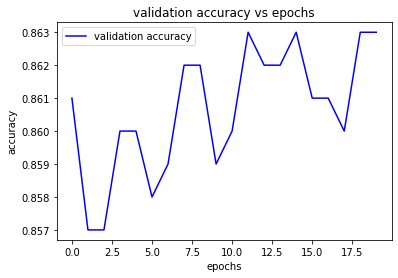

In [ ]:
epoch_list=[i for i in range(0,20)]
plt.plot( epoch_list,val_acc, label="validation accuracy",color='blue')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="best")
plt.title('validation accuracy vs epochs')
plt.show()
